## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### First, I'll compute the camera calibration using chessboard images

In [26]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for image in images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    corners_found, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if corners_found:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, corners_found)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### Now I have `objpoints` and `imgpoints` needed for camera calibration. The next step is to calibrate the camera, and calculate distortion coefficients using a distorted image:

Text(0.5,1,'Undistorted Image')

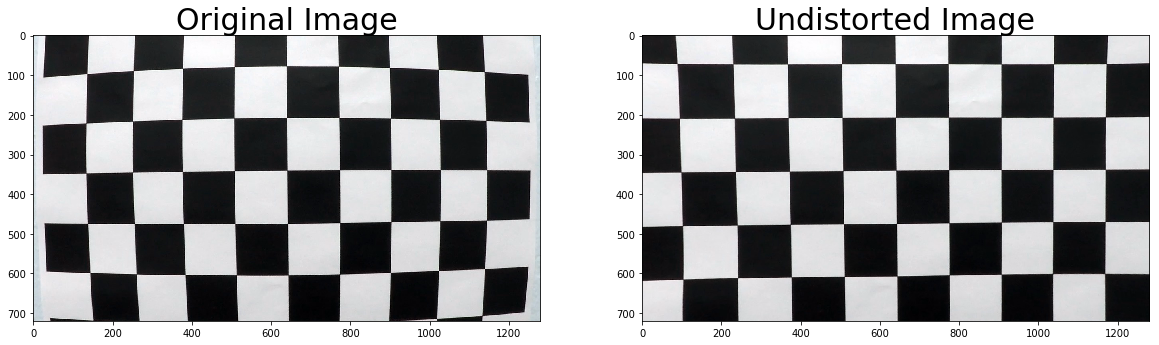

In [29]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('images/undist_cb_output.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [42]:
import pickle

# Save the calculated matrix & distortion coefficients for later use
dist_coeff_pickle = {}
dist_coeff_pickle["mtx"] = mtx
dist_coeff_pickle["dist"] = dist
pickle.dump(dist_coeff_pickle, open( "./dist_coeff.p", "wb" ) )

### With the calibrated camera (using the calculated matrix & distortion coefficients), now I can undistort any image as follows:

Text(0.5,1,'Undistorted Image')

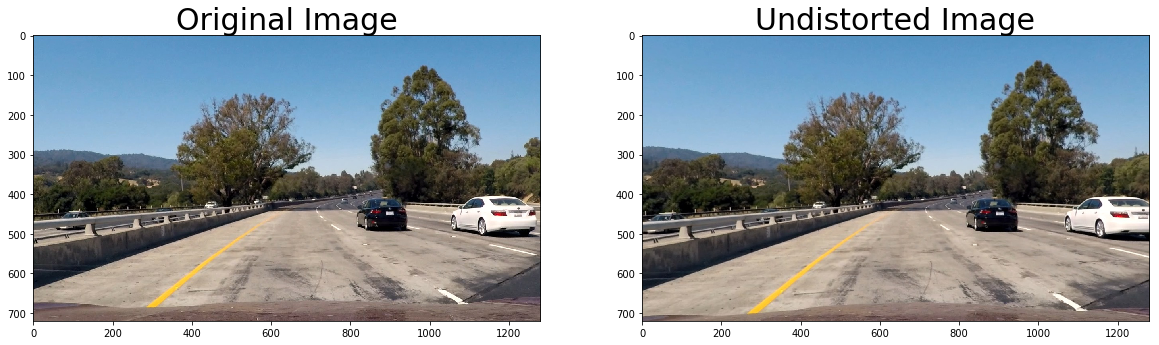

In [59]:
img = cv2.imread('./test_images/test1.jpg')

undst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./images/undist_test1.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(undst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

In [43]:
# This is optional. Useful when suspending & resuming work 
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "dist_coeff.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

### These helper functions to transform the image using Sobel X/Y, magnitude, HLS/HSV/RGB channel thresholds facilitate reuse of code and allow easy experimentation of various combinations. 

In [127]:
def transform_binary(raw, thresh):
    # 2) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    thresh_min, thresh_max = thresh
    binary_output = np.zeros_like(raw)
    binary_output[(raw >= thresh_min) & (raw <= thresh_max)] = 1
    return binary_output
    
def sobel_binary(abs_sobel, thresh):
    # 1) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    sobel_thresh = transform_binary(scaled_sobel, thresh)
    return sobel_thresh
    
def sobel_transform(gray, thresh, orient='x', kernel_size=5):
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F,
        int(orient == 'x'), int(orient == 'y'), ksize=kernel_size)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Generate output binary
    sobel_transformed = sobel_binary(abs_sobel, thresh)
    return sobel_transformed

def mag_transform(gray, thresh, kernel_size=5):
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    # 2) Calculate the magnitude
    abs_sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # 3) Generate output binary
    mag_transformed = sobel_binary(abs_sobel, thresh)
    return mag_transformed

def hls_transform(hls, thresh, space='S'):
    # Separate the H/L/S channel
    spaces = ['H', 'L', 'S']
    hls_channel = hls[:,:,spaces.index(space)]
    # Threshold S channel
    hls_transformed = transform_binary(hls_channel, thresh)
    return hls_transformed

def hsv_transform(hsv, thresh, space='H'):
    # Separate the H/L/S channel
    spaces = ['H', 'S', 'V']
    hsv_channel = hsv[:,:,spaces.index(space)]
    # Threshold S channel
    hsv_transformed = transform_binary(hsv_channel, thresh)
    return hsv_transformed

def color_transform(rgb, thresh, color='R'):
    # Separate the R/G/B channel
    colors = ['R', 'G', 'B']
    c_channel = rgb[:,:,colors.index(color)]
    single_transformed = transform_binary(c_channel, thresh)
    return single_transformed



In [269]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def corners_unwarp(img):
    img_shape = img.shape
    src = np.array([[ 
        (0.47 * img_shape[1], 0.62 * img_shape[0]),
        (0.54 * img_shape[1], 0.62 * img_shape[0]), 
        (0.86 * img_shape[1], img_shape[0]),
        (0.16 * img_shape[1], img_shape[0])
        ]], dtype=np.float32)
        #]], dtype=np.int32)
    dst = np.array([[ 
        (0.26 * img_shape[1], 0),
        (0.83 * img_shape[1], 0), 
        (0.75 * img_shape[1], img_shape[0]),
        (0.25 * img_shape[1], img_shape[0])
        ]], dtype=np.float32)
        #]], dtype=np.int32)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    #masked_image = region_of_interest(img, dst)
    #warped = masked_image
    return warped, M


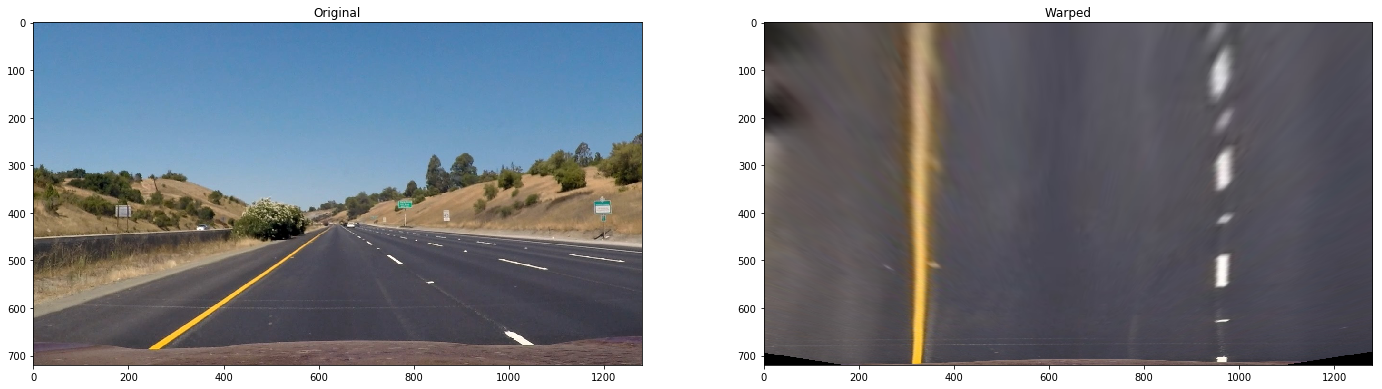

In [277]:
img = cv2.imread('./test_images/straight_lines1.jpg')
undst = cv2.undistort(img, mtx, dist, None, mtx)
warped, M = corners_unwarp(undst)
cv2.imwrite('./output_images/warped_straight_lines1.jpg', warped)
fig = plt.figure(figsize=(24, 9))
canvas = fig.add_subplot(1, 2, 1)
canvas.set_title('Original')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
canvas = fig.add_subplot(1, 2, 2)
canvas.set_title('Warped')
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

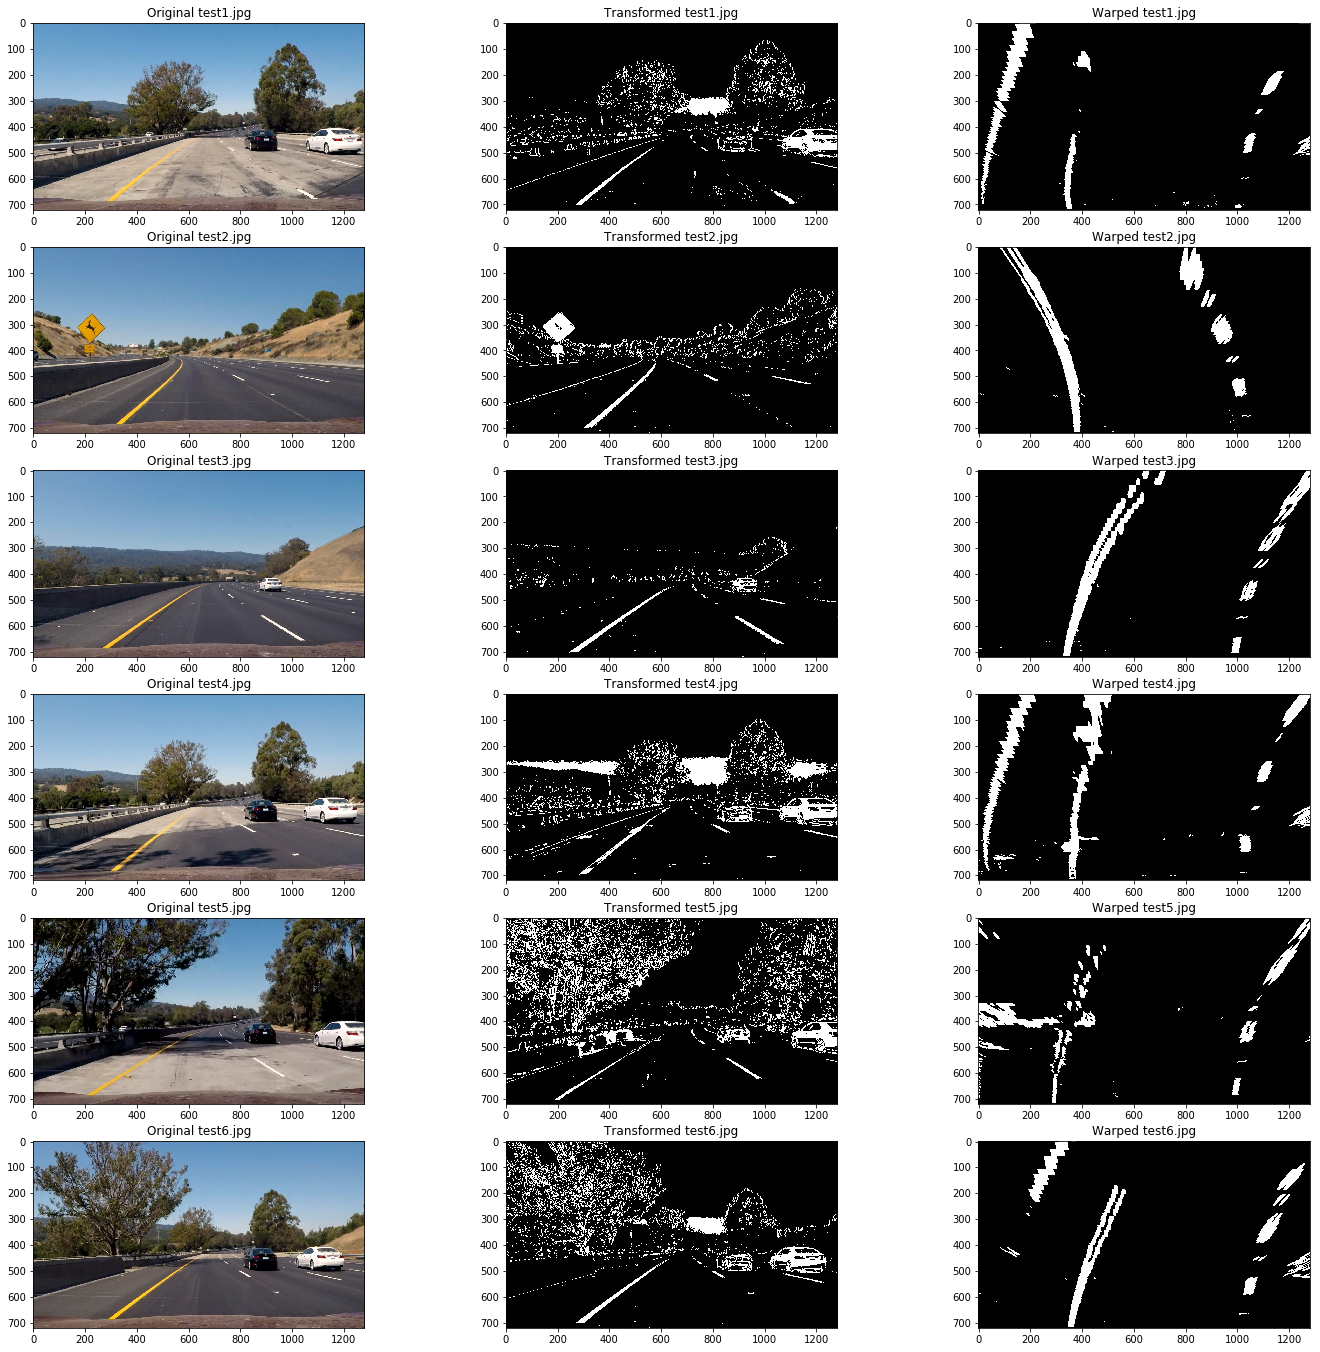

In [276]:
### Try various combinations of transforms defined above
def undistort_transform(img, mtx, dist, sobel_thresh=(30, 150), s_thresh=(180, 255), c_thresh=(202, 255)):
    # img is an original, possibly distorted image
    undst = cv2.undistort(img, mtx, dist, None, mtx)

    # Convert to HLS color space
    hls = cv2.cvtColor(undst, cv2.COLOR_BGR2HLS)
    # Threshold S channel
    s_binary = hls_transform(hls, s_thresh)
    
    # Grayscale image
    gray = cv2.cvtColor(undst, cv2.COLOR_BGR2GRAY)
    # Sobel x
    sxbinary = sobel_transform(gray, sobel_thresh)
    mag_binary = mag_transform(gray, sobel_thresh)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    # Threshold R, G channels
    r_binary = color_transform(undst, c_thresh)
    g_binary = color_transform(undst, c_thresh, color='G')
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (g_binary == 1)] = 1
    
    return combined_binary


# Step through the list of test images to see the results of the threshold transforms
images = glob.glob('./test_images/test*.jpg')

plt_scale = 8
num_images = len(images)
pos = 1
fig = plt.figure(figsize=(plt_scale * 3, plt_scale * num_images / 2))
transformed_images = []
for image in sorted(images):
    image_name = image.split('/')[-1]
    img = cv2.imread(image)
    
    # Plot the original image
    canvas = fig.add_subplot(num_images, 3, pos)
    canvas.set_title('Original ' + image_name)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    pos +=1
    
    # combined_binary1 = undistort_transform(image, mtx, dist, color_channel_thresh=False)
    combined_binary = undistort_transform(img, mtx, dist)
    transformed_images.append(combined_binary)
    # Save the transformation result
    cv2.imwrite('./output_images/combined_' + image_name, np.uint8(255 * combined_binary))
    
    # Plot the transformed image
    canvas = fig.add_subplot(num_images, 3, pos)
    canvas.set_title('Transformed ' + image_name)
    plt.imshow(combined_binary, cmap='gray')
    #plt.imshow(corners_unwarp(combined_binary), cmap='gray')
    pos +=1
    
    warped = cv2.warpPerspective(combined_binary, M, (img.shape[1], img.shape[0]))
    # Save the warping result
    cv2.imwrite('./output_images/warped_' + image_name, np.uint8(255 * warped))
    
    # Plot the result
    canvas = fig.add_subplot(num_images, 3, pos)
    canvas.set_title('Warped ' + image_name)
    plt.imshow(warped, cmap='gray')
    pos +=1
    
